<a href="https://colab.research.google.com/github/tnystul/DSCB225/blob/main/Code/Image_Analysis_Problem_Set_Answer_Key.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import packages, functions, and data

In [ ]:
# import python packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import skimage
import plotly.express as px

In [ ]:
# define functions

def subtract_background(image, background):
    dtype = image.dtype
    return np.clip(image.astype(np.int16) - background, 0, 65535).astype(dtype)

def random_cmap():
    np.random.seed(42)
    cmap = matplotlib.colors.ListedColormap (np.random.rand(256,4))
    # value 0 should just be transparent
    cmap.colors[:,3] = 0.5
    cmap.colors[0,:] = 1
    cmap.colors[0,3] = 0

    # if image is a mask, color (last value) should be red
    cmap.colors[-1,0] = 1
    cmap.colors[-1,1:3] = 0
    return cmap

In [ ]:
%%capture
!pip install -U tifffile
!pip install -U aicsimageio

from aicsimageio import AICSImage
!pip install aicspylibczi>=3.1.1 fsspec>=2022.8.0

In [ ]:
!wget https://ucsf.box.com/shared/static/3ij7e92913368qargvrjjxg704ceo4sk.tif -O image.tif

--2025-03-10 21:03:30--  https://ucsf.box.com/shared/static/3ij7e92913368qargvrjjxg704ceo4sk.tif
Resolving ucsf.box.com (ucsf.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to ucsf.box.com (ucsf.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/3ij7e92913368qargvrjjxg704ceo4sk.tif [following]
--2025-03-10 21:03:30--  https://ucsf.box.com/public/static/3ij7e92913368qargvrjjxg704ceo4sk.tif
Reusing existing connection to ucsf.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ucsf.app.box.com/public/static/3ij7e92913368qargvrjjxg704ceo4sk.tif [following]
--2025-03-10 21:03:30--  https://ucsf.app.box.com/public/static/3ij7e92913368qargvrjjxg704ceo4sk.tif
Resolving ucsf.app.box.com (ucsf.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to ucsf.app.box.com (ucsf.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response..

In [ ]:
data = AICSImage('/content/image.tif')
data.shape

(1, 3, 1, 241, 349)

In [ ]:
img = data.get_image_dask_data('CYX', c=1)
img.shape

(3, 241, 349)

# Segment the DAPI channel and count the number of cells in the image

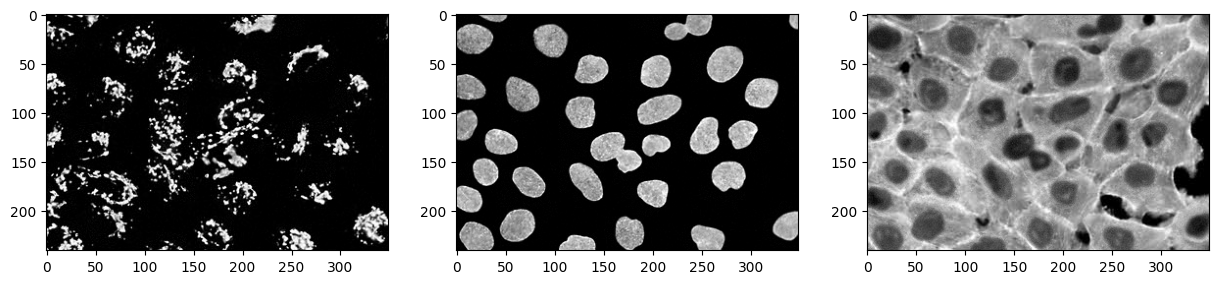

In [ ]:
# View the three channels using the plt.subplots function

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img[0, :, :], cmap='gray')
ax[1].imshow(img[1, :, :], cmap='gray')
ax[2].imshow(img[2, :, :], cmap='gray')

Text(0.5, 1.0, 'Cytoplasm')

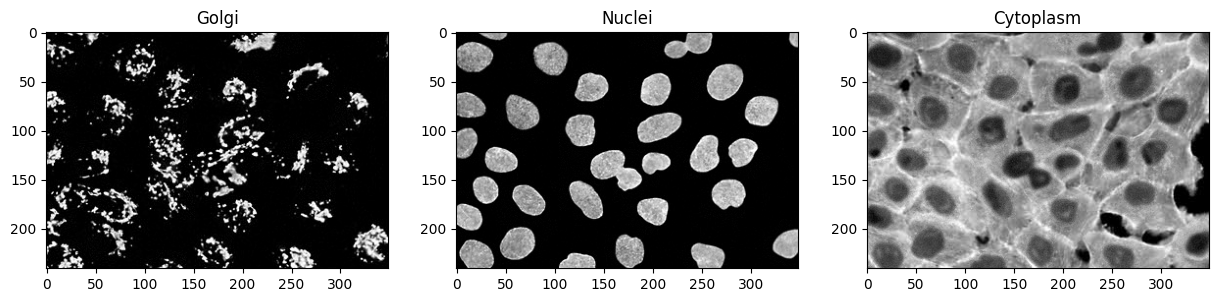

In [ ]:
 # plot them again, this time adding titles for the Golgi, nuclei, and cytoplasm channels

 fig, ax = plt.subplots(1, 3, figsize=(15, 5))

 ax[0].imshow(img[0, :, :], cmap='gray')
 ax[0].set_title('Golgi')
 ax[1].imshow(img[1, :, :], cmap='gray')
 ax[1].set_title('Nuclei')
 ax[2].imshow(img[2, :, :], cmap='gray')
 ax[2].set_title('Cytoplasm')

Use the px.histogram function to plot a histogram of the intensity values in
the Nuclei channel

In [ ]:
fig = px.histogram(img[1,:,:], nbins=100)
fig.show()

Based on the results of the histogram, plot 4 background subtraction options

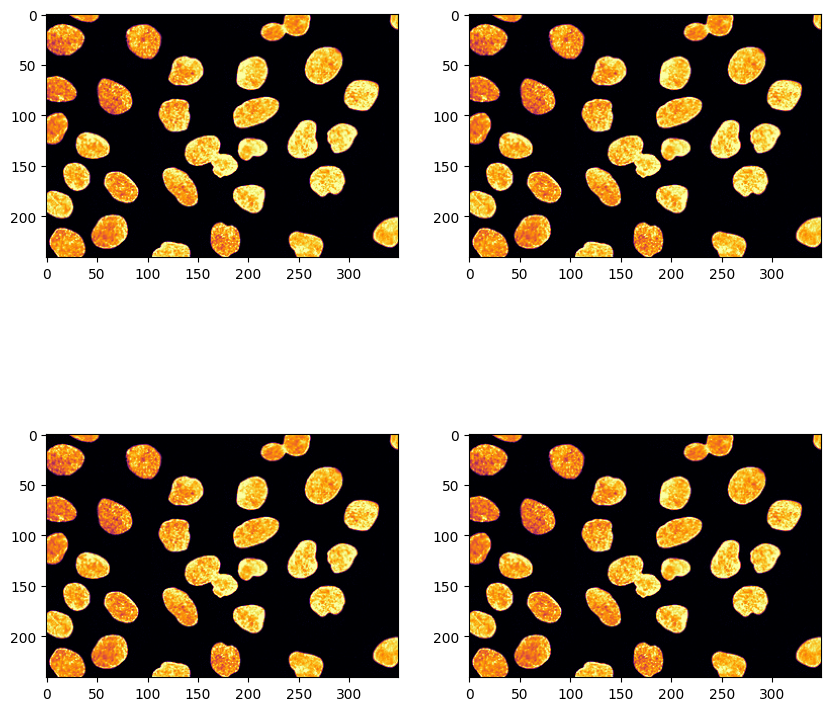

In [ ]:
fig = plt.figure(figsize=(10,10))

for x in range(1,5):
    img_temp = img.copy()
    img_temp = img_temp[1,:,:] - float((x+1) * 2.5)
    ax = fig.add_subplot(2,2,x)
    ax.imshow(img_temp, cmap = 'inferno', vmax=200)

Pick the one that looks best (in my answer, they all look pretty similar) and use that value to generate an image with the background subtracted from the Nuclei channel

In [ ]:
img_p = img.copy()
img_p[1,:,:] = subtract_background(img_p[1,:,:], 10)

Use the otsu filter to calculate a threshold for the Nuclei channel

In [ ]:
otsu = skimage.filters.threshold_otsu(img_p[1,:,:])
otsu

82

Generate a mask of the Nuclei channel using the otsu value.  Then, use the plt function to view the image and the mask side-by-side

In [ ]:
img_mask = img_p[1,:,:] > otsu

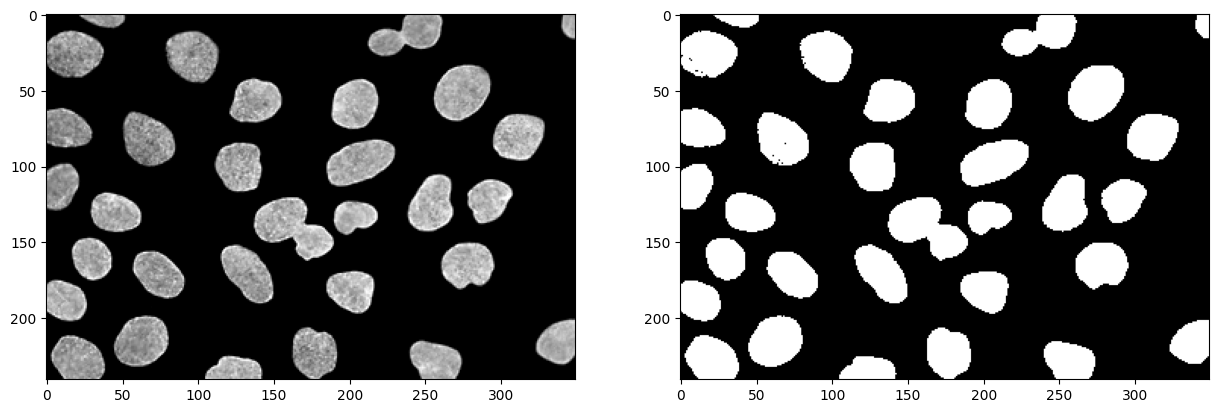

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].imshow(img_p[1,:,:], cmap='gray')
ax[1].imshow(img_mask, cmap='gray')

In [ ]:
def generate_template(radius):
  template = np.zeros((60,60))
  center = [(template.shape[0]-1)/2,(template.shape[1]-1)/2]
  Y, X = np.mgrid[0:template.shape[0],0:template.shape[1]]
  dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
  template[dist_from_center<=radius] = 1
  return(template)

Using the function above, write a for loop that will sample radii ranging from 10-18 and plot the results in a 3 x 3 grid.

*   Use ax = fig.add_subplot(3,3,x+1) to set up the subplots
*   Use ax.imshow to show the Nuclei
*   Use ax.scatter to show the local max indices
*   Use ax.title.set_text to title each subplot with the radius value



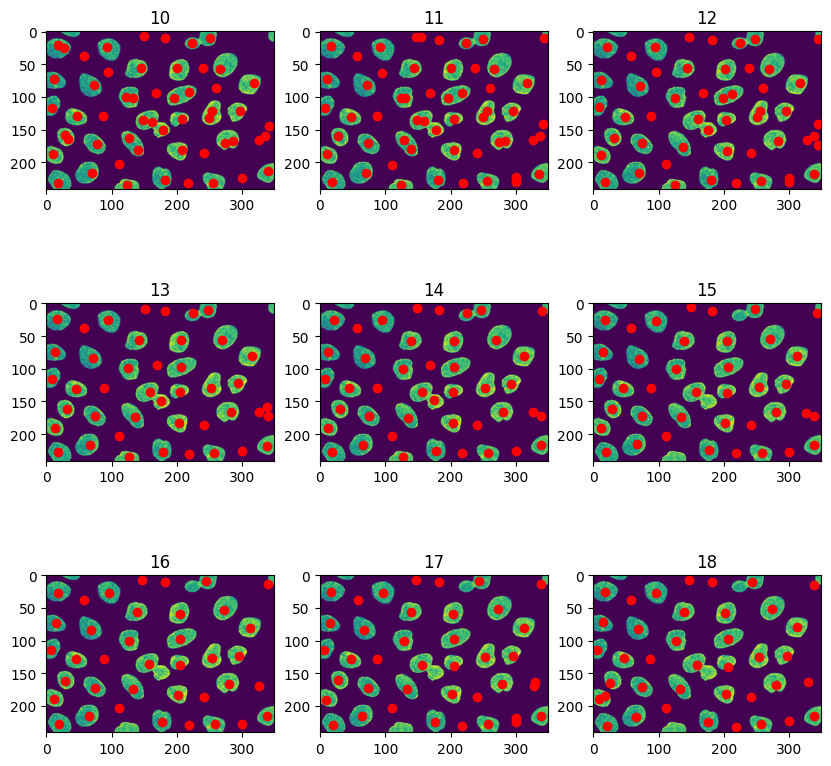

In [ ]:
fig = plt.figure(figsize=(10,10))

for x in range(9):
  template = generate_template(x + 10)
  matched = skimage.feature.match_template(image=img[1,:,:], template=template, pad_input=True)
  local = skimage.feature.peak_local_max(matched, min_distance=5)
  ax = fig.add_subplot(3,3,x+1)
  ax.imshow(img_p[1,:,:])
  ax.scatter(local[:,1], local[:,0], c='r')
  ax.title.set_text(x+10)


Select the radius value you like the most and use it to

*   Generate an array of local maxima called local_max_indicies
*   Generate a boolean array of the local maxima
*   Eliminate the points that do not overlap with the image mask
*   Get the peak coordinates
*   Plot the peaks on top of the Nuclear channel of the image

In [ ]:
template = generate_template(14)

matched = skimage.feature.match_template(image=img[1,:,:], template=template, pad_input=True)

local_max_indices = skimage.feature. peak_local_max(matched, min_distance=5)

In [ ]:
local_max = np.zeros_like(img_mask.compute(), dtype=bool)
local_max[tuple(local_max_indices.T)] = True

In [ ]:
masked_peaks = local_max & img_mask

In [ ]:
peak_coords = np.argwhere(masked_peaks.compute())

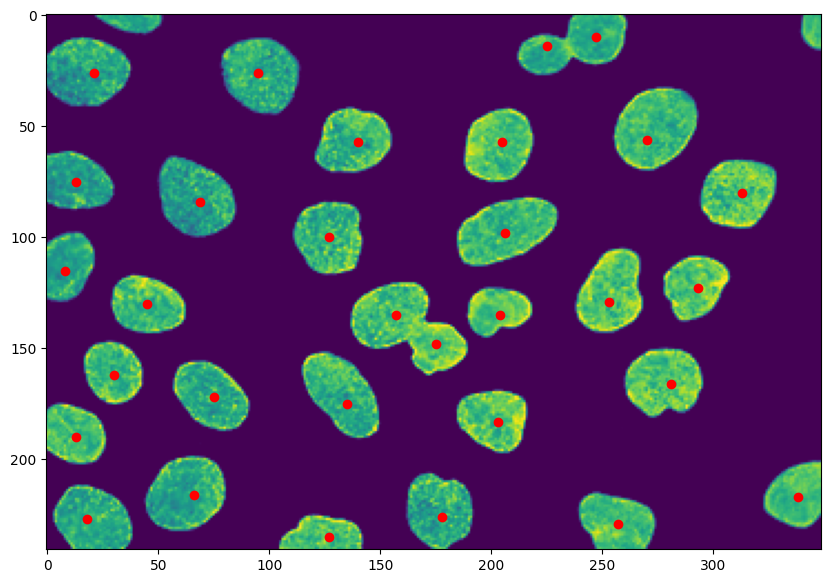

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img_p[1,:,:])
plt.plot(peak_coords[:,1],peak_coords[:,0],'ro');

Segment the image by

*   Generating labels from the masked peaks
*   Running the watershed algorithm, using img_p, the masked peaks, and the img_mask as inputs
*   define cmap using the random_cmap function and then plot the Nuclei and watershed labels together



In [ ]:
seed_label = skimage.morphology.label(masked_peaks)

watershed_labels = skimage.segmentation.watershed(image = -img_p[1,:,:].compute(),
                                                  markers = seed_label,
                                                  mask=img_mask,
                                                  watershed_line=True)

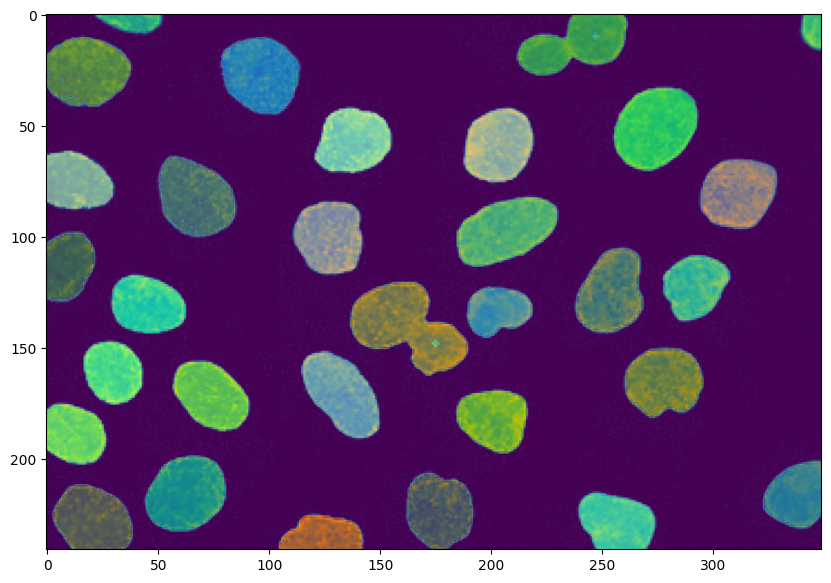

In [ ]:
cmap = random_cmap()

plt.figure(figsize = (10,10))
plt.imshow(img[1,:,:])
plt.imshow(watershed_labels, cmap = cmap);

Does that look right?  Try rerunning the watershed function again but this time, add in compactness = 3 as an additional parameter and plot the image and labels again.  What changed?

In [ ]:
watershed_labels = skimage.segmentation.watershed(image = -img_p[1,:,:].compute(),
                                                  markers = seed_label,
                                                  mask=img_mask,
                                                  compactness=3,
                                                  watershed_line=True)

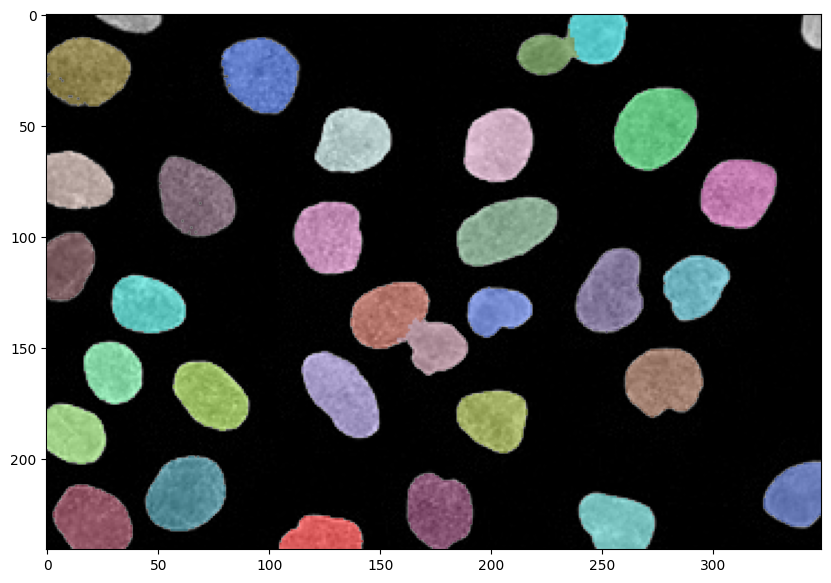

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(img[1,:,:], cmap='gray')
plt.imshow(watershed_labels, cmap = cmap);

Generate a regionprops table and print its shape.  How many nuclei are segmented in this image?

In [ ]:
regions = skimage.measure.regionprops_table(skimage.measure.label(watershed_labels),
                                            intensity_image=img_p[1,:,:].compute(),
                                            properties=('label','area','mean_intensity', 'coords'))

In [ ]:
region_pd = pd.DataFrame(regions)
region_pd.shape  #  There are 31 rows and therefore 31 nuclei segmented

(31, 4)

# Segment the cytoplasm channel and quantify the mean signal intensity per cell

Now, generate a cytoplasm mask performing the following steps:

*   Create a "watershed mask" of the Cytoplasm channel using the same labels you generated from the masked peaks and the watershed segmentation tool (set compactness = 1)
*   Create a "foreground mask" that identifies all the pixels with an intensity above 20 in the Cytoplasm channel.  
*   Remove the parts of the watershed mask that **do** overlap the nuclear masks, so the nuclear signal doesn't contribute to the nuclear signal
*   Remove the parts of the watershed mask that **do not** overlap with the foreground mask

Note, although masks are boolean (T/F) arrays, they can be used in equations and python interprets True as 1 and False as 0

In [ ]:
watershed_labels_cyto = skimage.segmentation.watershed(image = img_p[2,:,:].compute(),
                                                       markers = seed_label,
                                                       compactness=1,
                                                       watershed_line=True)

In [ ]:
foreground_mask = img_p[2,:,:] > 20

In [ ]:
watershed_labels_cyto = watershed_labels_cyto - watershed_labels
watershed_labels_cyto = watershed_labels_cyto * foreground_mask

Display the results in a figure with 3 subplots:  one showing the cytoplasm signal, one showing the cytoplasm mask, and one showing both of these images merged together

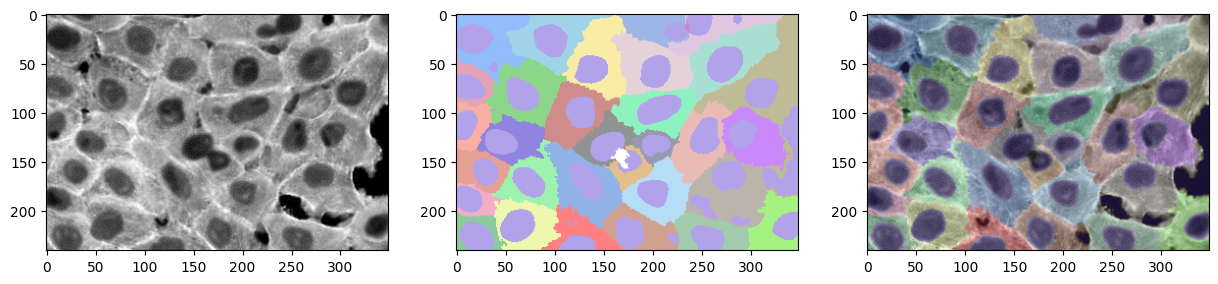

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img[2,:,:], cmap='gray')
ax[1].imshow(watershed_labels_cyto, cmap=cmap);
ax[2].imshow(img[2,:,:], cmap='gray')
ax[2].imshow(watershed_labels_cyto, cmap=cmap, alpha=0.5);

Measure the mean intensity of the cytoplasm channel and store the results as a Pandas DataFrame

In [ ]:
regions_cyto = skimage.measure.regionprops_table(skimage.measure.label(watershed_labels_cyto),
                                            intensity_image=img_p[2,:,:].compute(),
                                            properties=('label','area','mean_intensity', 'coords'))

In [ ]:
regions_cyto = pd.DataFrame(regions_cyto)
regions_cyto.head()

,label,area,mean_intensity,coords
0,1,2591.0,128.457352,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5..."
1,2,2662.0,144.939144,"[[0, 72], [0, 73], [0, 74], [0, 75], [0, 76], ..."
2,3,1508.0,156.039125,"[[0, 164], [0, 165], [0, 166], [0, 167], [0, 1..."
3,4,18.0,146.111111,"[[0, 235], [0, 236], [0, 237], [1, 234], [1, 2..."
4,5,1717.0,148.627839,"[[0, 260], [0, 261], [0, 262], [0, 263], [0, 2..."


Create a histogram showing the mean intensity values in each cell

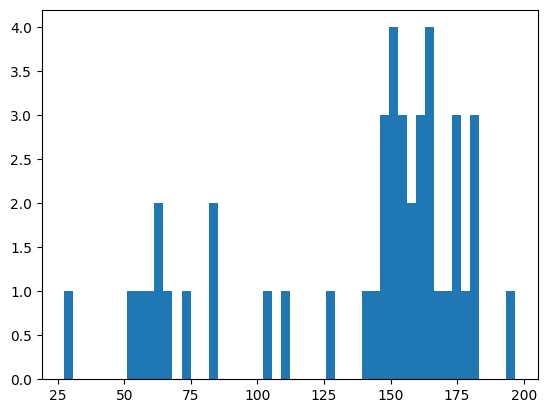

In [ ]:
plt.hist(regions_cyto['mean_intensity'], bins=50);